# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [11]:
import numpy as np
import numpy.linalg as la
import pandas as pd
from sklearn.linear_model import Lasso
from scipy.stats import norm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data 

In [12]:
from Project_2 import *
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

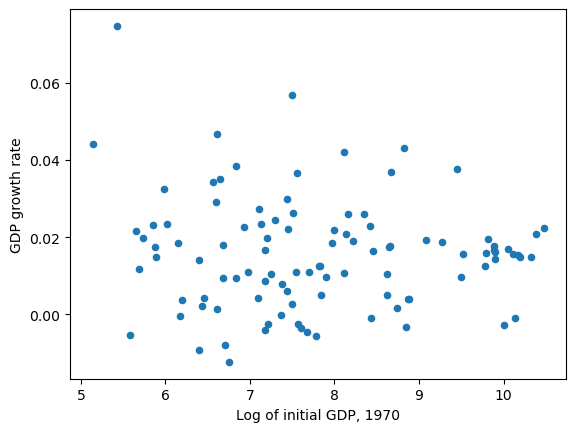

In [13]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth', ylabel='GDP growth rate', xlabel='Log of initial GDP, 1970');

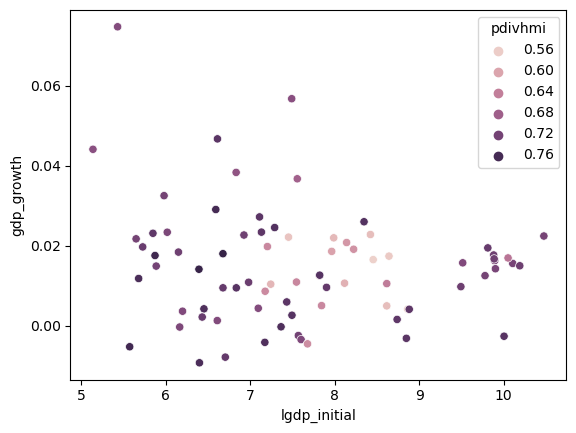

In [14]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='pdivhmi');

## Data-inspection
We begin by checking how many observations that has non-missing values for all variables.

In [15]:
non_missing_count = dat.dropna().shape[0]
print(f'The number of observations with non-missing values for all variables is {non_missing_count}.')

The number of observations with non-missing values for all variables is 13.


Next, we exclude seven variables; we exclude three variables ($'pother'$, $'europe'$ and $'lp\_bl'$) and use these as the baselines for other variables relating to the same topic. We exclude three variables ($'gdp\_initial'$, $'lpop\_initial'$ and $'PD1500.1'$) as these are perfectly correlated with other variables in the dataset. We exclude one variable ($'code'$) due to a lack of relevance for the analysis.

We then count the number of observations for each variable, conditional on 'gdp_growth' and 'lgdp_initial' being non-missing

In [16]:
sorted_data = filter_data(dat)

Filtered data displayed by non-missing values for each region:
                      Variable  All  Africa  Americas  Asia  Europe  Oceania
                         leb95   49      21        20     7       0        1
                         imr95   49      21        20     7       0        1
                       lt100km   50      21        20     8       0        1
                     mortality   50      19        21     8       1        1
                      excolony   53      17        15    11       8        2
                      democ00a   65      32        20    10       0        3
                        democ1   65      32        20    10       0        3
                   imputedmort   66      26        22    12       3        3
                       cons00a   68      32        23    10       0        3
                        logem4   70      28        24    12       3        3
                    pdivhmi_aa   76      32        19    14      11        0
    capital_g

## Collection of variables
In order to ease the following analysis, we group ALL the given variables into subcategories. Based on our data-inspection we exclude a range of variables from the analysis. These are grouped in 'vv_excluded'.

In [17]:
# extracting the variables we will need for further analysis
vv_outcome, vv_key, vv_excluded, vv_all = group_data(dat)

list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

print(f'Variables in total: {len(vv_all["all"]+vv_key+vv_outcome+vv_excluded)}')
print(f'We include {len(vv_all["all"])} control variables in total.')

Variables in total: 85
We include 64 control variables in total.


## Representativity of choosen variables
We check how many observations have non-missing values for ALL the included 66 variables (our two key variables and 64 control variables). We compare this to the corresponding number of observations if all variables (except the two key variables) are excluded.

In [18]:
all_included = vv_all['all'] + vv_outcome + vv_key

non_missing_all_included = dat[all_included].notnull().all(axis=1).sum()
print(f'Non-missing values in all included variables: {non_missing_all_included}')

Non-missing values in all included variables: 50


We then check how the observations with non-missing values are distributed across the different geographic regions to get an idea about how representative the remaining observations are. We derive this geographic distribution for all observations ('All_share'), those observations with non-missing values for our key variables ('Key_share'), and those with non-missing values for all the included variables ('Included_share').

In [19]:
regions = ['africa', 'americas', 'asia', 'europe', 'oceania']
table = investigate_data(regions, dat, vv_outcome, vv_key, vv_all)
print(table)

     Region  All_share (%)  Included_share (%)
0    Africa          25.23                24.0
1  Americas          19.63                26.0
2      Asia          22.90                22.0
3   Oceania           7.94                 2.0
4    Europe          21.50                26.0


We conclude that the included variables resemble the geographic distribution of the full data set to a reasonable extent, i.e. there there is no extreme regional bias in our included variables.

In [20]:
print(pd.DataFrame.to_latex(table, index=False))

\begin{tabular}{lrr}
\toprule
Region & All_share (%) & Included_share (%) \\
\midrule
Africa & 25.230000 & 24.000000 \\
Americas & 19.630000 & 26.000000 \\
Asia & 22.900000 & 22.000000 \\
Oceania & 7.940000 & 2.000000 \\
Europe & 21.500000 & 26.000000 \\
\bottomrule
\end{tabular}



## Preparing data for analysis
We create a new data set consisting only of the non-missing observations and the included variables. We add a constant to the data (mainly relevant for OLS analysis), and base our analysis on this new dataset.

In [21]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))
vv_constant = ['constant']

included_rows = dat[vv_outcome + vv_key + vv_all['all']].notnull().all(axis=1)
data = dat[included_rows]

data = data[vv_all['all'] + vv_outcome + vv_key + vv_constant]
print(data.shape)
print(f'There are {data.isnull().sum().sum()} missing observations in the data.')

(50, 67)
There are 0 missing observations in the data.


In [22]:
# We define our variables of interest, which will be used for all the following analysis
g = data[vv_outcome].squeeze() #*100 to get it in percentage and not decimals
y0 = data[vv_key].squeeze()
Z_basic = data[vv_all['all']]
Z = PolynomialFeatures(1, include_bias=False).fit_transform(Z_basic)

X = np.column_stack((y0,Z))
N = X.shape[0]

# Standardize data using the function in our py.file
X_tilde = standardize(X)
Z_tilde = standardize(Z)
y0_tilde = standardize(y0)

# Calculate the z-statistic for future use (two sided 95% confidence interval)
q = z_stat()

# Create a DataFrame with X_names as the index
Z_names = Z_basic.columns
X_names = Z_names.insert(0, y0.name)
print(f'The first five rows of our name dataframe are: {X_names[:5]}')

The first five rows of our name dataframe are: Index(['lgdp_initial', 'dem', 'demCGV', 'demBMR', 'demreg'], dtype='object')


# Data analysis

## Lasso estimation

### Based on BRT penalty

#### Post-single Lasso

All functions are defined in the Project_2.py file

In [23]:
''' Step 1: Calculate BRT penalty '''
penalty_BRT = BRT(X_tilde,g)

''' Step 2: Lasso g using y0 and Z (i.e. g using X) '''
fit_BRTgx, coeff_BRTgx, intercept_BRTgx = lasso(X_tilde, g, penalty_BRT)

# Implied estimates and selection of non-zero coefficient variables for further analysis
Z_J_BRTgx = Z[:,coeff_BRTgx[1:]!=0] # Note: We use Z and not Z_tilde
selected_variables_BRTgx = (coeff_BRTgx != 0)

# Display number of variables in Z_J
if Z_J_BRTgx.size > 0: # if Z_J is non-empty and variables have been selected
    print("The number of variables in Z_J is {}".format(Z_J_BRTgx.shape[1]))
    print('Selected varriables: ', X_names[selected_variables_BRTgx].to_list())
else: # if Z_J is empty
    print("The number of variables in Z_J is 0, no variables selected.")

''' Step 3: Regress g using y0 and Z_J (selected variables) '''
# Add a constant to X
xx = np.column_stack((np.ones(N),y0,Z_J_BRTgx))
yy = np.array(g).reshape(-1,1)

# Calculate OLS estimate
coefs_BRT_PSL = la.inv(xx.T@xx)@xx.T@yy
coef_BRT_PSL = coefs_BRT_PSL[1][0]

#print the coefficients
pd.DataFrame(coefs_BRT_PSL, index=['constant', 'lgdp_initial'], columns=['gdp_growth']) #same as for the simple OLS above


lambda_BRT = 0.0065
Intercept/constant:  0.016
Coefficients:  [-0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.
  0. -0.  0.  0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0.
  0. -0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0.]
The number of variables in Z_J is 0, no variables selected.


,gdp_growth
constant,0.031571
lgdp_initial,-0.001865


Next we analyse our result by calculating the 95 % confidence interval for ${\beta}_{y0}$ (BRT_PSL)

In [24]:
# Estimate variance
var_BRT_PSL = var_single(xx,yy,coefs_BRT_PSL)

# Calculate standard errors
se_BRT_PSL = standard_errors(var_BRT_PSL)
print("se_BRT_PSL = ",se_BRT_PSL.round(5))

# Calculate confidence interval
CI_low_BRT_PSL  = coef_BRT_PSL-q*se_BRT_PSL
CI_high_BRT_PSL = coef_BRT_PSL+q*se_BRT_PSL

# Display confidence interval
print("Confidence interval for β_y0 (BRT_PSL) = ",(CI_low_BRT_PSL.round(5),CI_high_BRT_PSL.round(5)))

se_BRT_PSL =  0.00126
Confidence interval for β_y0 (BRT_PSL) =  (-0.00434, 0.00061)


**Conclusion (BRT_PSL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Post-double Lasso

Step 1 & 2: Same as for Post-single Lasso

Step 3: Lasso D using Z

In [25]:
''' Step 1: Calculate BRT penalty '''
penalty_BRTy0z = BRT(Z_tilde, y0)

''' Step 2: Lasso y0 using X_tilde '''
fit_BRTy0z, coeff_BRTy0z, intercept_BRTy0z = lasso(X_tilde, y0, penalty_BRTy0z)

# Implied estimates and selection of non-zero coefficient variables for further analysis
selected_variables_BRTy0z = (coeff_BRTy0z != 0)

if selected_variables_BRTy0z.size > 0: # if Z_J is non-empty and variables have been selected
    print('Selected varriables: ', X_names[selected_variables_BRTy0z].to_list())
else: # if Z_J is empty
    print("The number of variables in Z_J is 0, no variables selected.")


lambda_BRT = 0.7205
Intercept/constant:  8.164
Coefficients:  [ 0.644  0.     0.     0.     0.    -0.     0.     0.    -0.    -0.
 -0.    -0.    -0.    -0.     0.    -0.    -0.    -0.    -0.     0.
  0.    -0.    -0.    -0.    -0.    -0.    -0.     0.    -0.     0.
  0.    -0.     0.    -0.    -0.     0.     0.    -0.    -0.     0.
 -0.    -0.    -0.    -0.     0.     0.    -0.    -0.    -0.    -0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.
  0.     0.     0.     0.     0.   ]
Selected varriables:  ['lgdp_initial']


Step 4: Estimate ${\beta}_{y0}$ (called 'alpha' in the slides)

In [27]:
# Calculate residuals
res_BRTgx = g - fit_BRTgx.predict(X_tilde)
res_BRTgxz = res_BRTgx + y0_tilde * coeff_BRTgx[0]
res_BRTy0z = y0 - fit_BRTy0z.predict(Z_tilde)

# Calculate beta_y0
num = res_BRTy0z @ res_BRTgxz
denom = res_BRTy0z @ y0
coef_BRT_PDL = num/denom

# Display beta_y0
print("Coefficient for β_y0 (BRT_PDL) = ",coef_BRT_PDL.round(5))

ValueError: X has 64 features, but Lasso is expecting 65 features as input.

Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BRT_PDL)

In [29]:
# Calculate variance    
sigma2_BRT_PDL = var_double(X_tilde, res_BRTy0z, res_BRTgx)

# Calculate standard error
se_BRT_PDL = standard_errors(sigma2_BRT_PDL)

# Display standard error
print("se_BRT_PDL = ",se_BRT_PDL.round(5))

# Calculate confidence interval
CI_low_BRT_PDL  = coef_BRT_PDL-q*se_BRT_PDL
CI_high_BRT_PDL = coef_BRT_PDL+q*se_BRT_PDL

# Display confidence interval
print("Confidence interval for β_y0 (BRT_PDL) = ",(CI_low_BRT_PDL.round(5),CI_high_BRT_PDL.round(5)))


NameError: name 'res_BRTy0z' is not defined

**Conclusion (BRT_PDL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Based on BCCH penalty

#### Post-single Lasso

All steps are the same for Single Lasso, we just use a different penalty rule.

In [31]:
# Caluclate the BRT penalty
penalty_BCCH = BCCH(X_tilde,g)

# Implied estimates and selection
fit_BCCHgx, coeff_BCCHgx, intercept_BCCHgx = lasso(X_tilde, g, penalty_BCCH)

Z_J_BCCHgx = Z[:,coeff_BCCHgx[1:]!=0] # Note: We use Z and not Z_stan

# Display number of variables in Z_J
print("The number of variables in Z_J is {}".format(Z_J_BCCHgx.shape[1]))
selected_variables_BCCHgx = (coeff_BCCHgx != 0)
print('Selected varriables: ', X_names[selected_variables_BCCHgx].to_list())


lambda_BCCH = 0.0098
Intercept/constant:  0.016
Coefficients:  [-0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.
  0. -0.  0.  0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0.
  0. -0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0.]
The number of variables in Z_J is 0
Selected varriables:  []


**Conclusion (BCCH_PSL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Post-double Lasso

Step 1 & 2: Same as for Post-single Lasso

Step 3: Lasso D using Z

In [32]:
penalty_BCCHy0z = BCCH(Z_tilde, y0)

# Run Lasso
fit_BCCHy0z, coeff_BCCHy0z, intercept_BCCHy0z = lasso(Z_tilde, y0, penalty_BCCHy0z)

selected_variables_BCCHy0z = (coeff_BCCHy0z != 0)
print('Selected varriables: ', Z_names[selected_variables_BCCHy0z].to_list())

lambda_BCCH = 1.0827
Intercept/constant:  8.164
Coefficients:  [ 0.     0.     0.     0.    -0.     0.     0.    -0.    -0.    -0.
 -0.    -0.    -0.     0.    -0.    -0.    -0.    -0.     0.     0.
 -0.    -0.    -0.    -0.    -0.    -0.     0.    -0.     0.     0.
 -0.     0.    -0.    -0.     0.     0.    -0.    -0.     0.    -0.
 -0.    -0.    -0.     0.     0.    -0.    -0.    -0.    -0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.    -0.     0.
  0.127  0.     0.     0.   ]
Selected varriables:  ['gdp_pc_initial']


Step 4: Estimate ${\beta}_{y0}$ (called 'alpha' in the slides)

In [33]:
# Calculate residuals
res_BCCHgx = g - fit_BCCHgx.predict(X_tilde)
res_BCCHgxz = res_BCCHgx + y0_tilde*coeff_BCCHgx[0]
res_BCCHy0z=y0-fit_BCCHy0z.predict(Z_tilde)

# Calculate beta_y0
num = res_BCCHy0z@res_BCCHgxz
denom = res_BCCHy0z@y0
coef_BCCH_PDL = num/denom

# Display beta_y0
print("Coefficient for β_y0 (BCCH_PDL) = ",coef_BCCH_PDL.round(5))

Coefficient for β_y0 (BCCH_PDL) =  -0.00193


Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BCCH_PDL)

In [34]:
# Calculate variance    
num = res_BCCHy0z**2@res_BCCHgx**2/N
denom = (res_BCCHy0z.T@res_BCCHy0z/N)**2
sigma2_BCCH_PDL = num/denom

# Calculate standard error
se_BCCH_PDL = np.sqrt(sigma2_BCCH_PDL/N)

# Display standard error
print("se_BCCH_PDL = ",se_BCCH_PDL.round(5))

# Calculate the z statistic that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_BCCH_PDL  = coef_BCCH_PDL-q*se_BCCH_PDL
CI_high_BCCH_PDL = coef_BCCH_PDL+q*se_BCCH_PDL

# Display confidence interval
print("Confidence interval for β_y0 (BCCH_PDL) = ",(CI_low_BCCH_PDL.round(5),CI_high_BCCH_PDL.round(5)))



se_BCCH_PDL =  0.00114
Confidence interval for β_y0 (BCCH_PDL) =  (-0.00416, 0.00031)


**Conclusion (BCCH_PDL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

In [35]:
BRT_PSL_results={'β_y0': coef_BRT_PSL, 'SE': se_BRT_PSL, 'CI_low': CI_low_BRT_PSL, 'CI_high': CI_high_BRT_PSL}
BRT_PDL_results={'β_y0': coef_BRT_PDL, 'SE': se_BRT_PDL, 'CI_low': CI_low_BRT_PDL, 'CI_high': CI_high_BRT_PDL}
BCCH_PSL_results={'β_y0': coef_BRT_PSL, 'SE': se_BRT_PSL, 'CI_low': CI_low_BRT_PSL, 'CI_high': CI_high_BRT_PSL}
BCCH_PDL_results={'β_y0': coef_BCCH_PDL, 'SE': se_BCCH_PDL, 'CI_low': CI_low_BCCH_PDL, 'CI_high': CI_high_BCCH_PDL}

all_results_1=pd.DataFrame([BRT_PSL_results, BRT_PDL_results, BCCH_PSL_results, BCCH_PDL_results], index=['PSL (BRT)', 'PDL (BRT)', 'PSL (BCCH)', 'PDL (BCCH)'])
print('Latex code for table 2:')
print(pd.DataFrame.to_latex(all_results_1,index=0))


penalty_1=pd.DataFrame([penalty_BRT.round(4), penalty_BCCH.round(4)], index=['BRT', 'BCCH'], columns=['Penalty'])
print('Latex code for table 3:')
print(pd.DataFrame.to_latex(penalty_1))

NameError: name 'coef_BRT_PDL' is not defined

# Analysis 2 (based on dataset with fewer variables / more observations)

## Preparing data for analysis
First we create a dataset (data2) consisting of those observations which have non-missing values for gdp_growth, lgdp_initial and investment_rate (these variables are explictly mentioned in the assignment text).
We then subset data2 such that it include only variables with zero missing values.

In [36]:
included_rows2 = dat[vv_outcome + vv_key + ['investment_rate'] ].notnull().all(axis=1)
data2 = dat[included_rows2]

data2 = data2.dropna(axis=1)

print(f'The number of observations left in data2 is {data2.shape[0]}.')
print(f'The number of variables with no missing values is {data2.shape[1]}.')
print(f'The remaining variables are: {data2.columns.to_list()}')

The number of observations left in data2 is 99.
The number of variables with no missing values is 28.
The remaining variables are: ['code', 'uvdamage', 'pdiv', 'legor_uk', 'legor_fr', 'area', 'cenlong', 'africa', 'europe', 'asia', 'oceania', 'americas', 'pprotest', 'pcatholic', 'pmuslim', 'pother', 'population_initial', 'population_now', 'gdp_pc_initial', 'gdp_pc_now', 'gdp_initial', 'gdp_now', 'investment_rate', 'gdp_growth', 'pop_growth', 'lgdp_initial', 'lpop_initial', 'constant']


In [41]:
g = data2[vv_outcome].squeeze() #*100 to get it in percentage and not decimals
y0 = data2[vv_key].squeeze()
Z_basic = data2.drop(["gdp_growth", "lgdp_initial",  # Drop outcome and key explanatory variable
                      "code", "constant", "gdp_initial", "lpop_initial", "pother", "europe"], axis=1) # Drop irrelevant/perfectly correlated/reference variables
Z2 = PolynomialFeatures(1, include_bias=False).fit_transform(Z_basic)
X = np.column_stack((y0,Z2))
N = X.shape[0]

# Standardize data
X_tilde = standardize(X)
Z_tilde = standardize(Z2)
y0_tilde = standardize(y0)

print(f'The number of variables in Z is {Z2.shape[1]}.')

The number of variables in Z is 20.


In [42]:
# Create a DataFrame with X_names as the index
Z_names = Z_basic.columns
X_names = Z_names.insert(0, y0.name)
print(X_names)

Index(['lgdp_initial', 'uvdamage', 'pdiv', 'legor_uk', 'legor_fr', 'area',
       'cenlong', 'africa', 'asia', 'oceania', 'americas', 'pprotest',
       'pcatholic', 'pmuslim', 'population_initial', 'population_now',
       'gdp_pc_initial', 'gdp_pc_now', 'gdp_now', 'investment_rate',
       'pop_growth'],
      dtype='object')


## Lasso estimation

### Based on BRT penalty

#### Post-single Lasso

Step 1: Calculate BRT penalty

In [43]:
# Make a function that calculates BRT.
penalty_BRT2 = BRT(X_tilde,g)

# Implied estimates and selection
fit_BRTgx2, coeff_BRTgx2, intercept_BRTgx2 = lasso(X_tilde, g, penalty_BRT2)

Z_J_BRTgx = Z2[:,coeff_BRTgx[1:]!=0] # Note: We use Z and not Z_stan

# Display number of variables in Z_J
print("The number of variables in Z_J is {}".format(Z_J_BRTgx.shape[1]))
selected_variables_BRTgx = (coeff_BRTgx != 0)
print('Selected varriables: ', X_names[selected_variables_BRTgx].to_list())

lambda_BRT = 0.005
Intercept/constant:  0.016
Coefficients:  [-0.    -0.    -0.     0.    -0.     0.     0.    -0.     0.002 -0.
 -0.    -0.    -0.    -0.     0.001  0.     0.     0.     0.     0.
 -0.   ]


IndexError: boolean index did not match indexed array along dimension 1; dimension is 20 but corresponding boolean dimension is 64

Step 3: Regress g using y0 and Z_J

In [44]:
# Add a constant to X
xx = np.column_stack((np.ones(N),y0,Z_J_BRTgx))
yy = np.array(g).reshape(-1,1)

# Calculate OLS estimate
coefs_BRT_PSL = la.inv(xx.T@xx)@xx.T@yy
coef_BRT_PSL = coefs_BRT_PSL[1][0]

#print the coefficients
pd.DataFrame(coefs_BRT_PSL, index=[['constant', 'lgdp_initial']+X_names[selected_variables_BRTgx].to_list()], columns=['gdp_growth']) #same as for the simple OLS above

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 99 and the array at index 2 has size 50

Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BRT_PSL)

In [ ]:
# Estimate variance
res_BRT_PSL = yy - xx@coefs_BRT_PSL
SSR_BRT_PSL = res_BRT_PSL.T@res_BRT_PSL
sigma2_BRT_PSL = SSR_BRT_PSL/(N-xx.shape[1])
var_BRT_PSL = sigma2_BRT_PSL*la.inv(xx.T@xx)

# Calculate standard errors
se_BRT_PSL = np.sqrt(np.diagonal(var_BRT_PSL)).reshape(-1, 1)
se_BRT_PSL=se_BRT_PSL[1][0]

# Display standard error
print("se_BRT_PSL = ",se_BRT_PSL.round(5))

# Calculate confidence interval
CI_low_BRT_PSL  = coef_BRT_PSL-q*se_BRT_PSL
CI_high_BRT_PSL = coef_BRT_PSL+q*se_BRT_PSL

# Display confidence interval
print("Confidence interval for β_y0 (BRT_PSL) = ",(CI_low_BRT_PSL.round(5),CI_high_BRT_PSL.round(5)))

**Conclusion (BRT_PSL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Post-double Lasso

Step 1 & 2: Same as for Post-single Lasso

Step 3: Lasso D using Z

In [ ]:
penalty_BRTy0z2 = BRT(Z_tilde, y0)

# Run Lasso
fit_BRTy0z2, coeff_BRTy0z2, intercept_BRTy0z2 = lasso(Z_tilde, y0, penalty_BRTy0z2)

selected_variables_BRTy0z = (coeff_BRTy0z != 0)
print('Selected varriables: ', Z_names[selected_variables_BRTy0z].to_list())

Step 4: Estimate ${\beta}_{y0}$ (called 'alpha' in the slides)

In [ ]:
# Calculate residuals
res_BRTgx = g - fit_BRTgx.predict(X_tilde)
res_BRTgxz = res_BRTgx + y0_tilde*coeff_BRTgx[0]
res_BRTy0z=y0-fit_BRTy0z.predict(Z_tilde)

# Calculate beta_y0
num = res_BRTy0z@res_BRTgxz
denom = res_BRTy0z@y0
coef_BRT_PDL = num/denom

# Display beta_y0
print("Coefficient for β_y0 (BRT_PDL) = ",coef_BRT_PDL.round(5))

Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BRT_PDL)

In [ ]:
# Calculate variance    
num = res_BRTy0z**2@res_BRTgx**2/N
denom = (res_BRTy0z.T@res_BRTy0z/N)**2
sigma2_BRT_PDL = num/denom

# Calculate standard error
se_BRT_PDL = np.sqrt(sigma2_BRT_PDL/N)

# Display standard error
print("se_BRT_PDL = ",se_BRT_PDL.round(5))

# Calculate confidence interval
CI_low_BRT_PDL  = coef_BRT_PDL-q*se_BRT_PDL
CI_high_BRT_PDL = coef_BRT_PDL+q*se_BRT_PDL

# Display confidence interval
print("Confidence interval for β_y0 (BRT_PDL) = ",(CI_low_BRT_PDL.round(5),CI_high_BRT_PDL.round(5)))

**Conclusion (BRT_PDL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Based on BCCH penalty

#### Post-single Lasso

Step 1: Calculate BCCH penalty

In [45]:
penalty_BCCH2 = BCCH(X_tilde,g)

# Implied estimates and selection
fit_BCCHgx2, coeff_BCCHgx2, intercept_BCCHgx2 = lasso(X_tilde, g, penalty_BCCH2)

Z_J_BCCHgx = Z[:,coeff_BCCHgx[1:]!=0] # Note: We use Z and not Z_stan

# Display number of variables in Z_J
print("The number of variables in Z_J is {}".format(Z_J_BCCHgx.shape[1]))
selected_variables_BCCHgx = (coeff_BCCHgx != 0)
print('Selected varriables: ', X_names[selected_variables_BCCHgx].to_list())

lambda_BCCH = 0.016
Intercept/constant:  0.016
Coefficients:  [-0. -0. -0.  0. -0.  0.  0. -0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0.
  0.  0. -0.]


IndexError: boolean index did not match indexed array along dimension 1; dimension is 20 but corresponding boolean dimension is 64

**Conclusion (BCCH_PSL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Post-double Lasso

Step 1 & 2: Same as for Post-single Lasso

Step 3: Lasso D using Z

In [47]:
penalty_BCCHy0z = BCCH(Z_tilde, y0)

# Run Lasso
fit_BCCHy0z2, coeff_BCCHy0z2, intercept_BCCHy0z2 = lasso(Z_tilde, y0, penalty_BCCHy0z)

selected_variables_BCCHy0z = (coeff_BCCHy0z != 0)
print('Selected varriables: ', Z_names[selected_variables_BCCHy0z].to_list())

lambda_BCCH = 0.6238
Intercept/constant:  7.82
Coefficients:  [-0.    -0.    -0.     0.     0.    -0.    -0.    -0.     0.     0.
  0.     0.    -0.    -0.    -0.     0.555  0.     0.     0.    -0.   ]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 20 but corresponding boolean dimension is 64

Step 4: Estimate ${\beta}_{y0}$ (called 'alpha' in the slides)

In [ ]:
# Calculate residuals
res_BCCHgx = g - fit_BCCHgx.predict(X_tilde)
res_BCCHgxz = res_BCCHgx + y0_tilde*coeff_BCCHgx[0]
res_BCCHy0z=y0-fit_BCCHy0z.predict(Z_tilde)

# Calculate beta_y0
num = res_BCCHy0z@res_BCCHgxz
denom = res_BCCHy0z@y0
coef_BCCH_PDL = num/denom

# Display beta_y0
print("Coefficient for β_y0 (BCCH_PDL) = ",coef_BCCH_PDL.round(5))

Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BCCH_PDL)

In [ ]:
# Calculate variance    
num = res_BCCHy0z**2@res_BCCHgx**2/N
denom = (res_BCCHy0z.T@res_BCCHy0z/N)**2
sigma2_BCCH_PDL = num/denom

# Calculate standard error
se_BCCH_PDL = np.sqrt(sigma2_BCCH_PDL/N)

# Display standard error
print("se_BCCH_PDL = ",se_BCCH_PDL.round(5))

# Calculate the z statistic that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_BCCH_PDL  = coef_BCCH_PDL-q*se_BCCH_PDL
CI_high_BCCH_PDL = coef_BCCH_PDL+q*se_BCCH_PDL

# Display confidence interval
print("Confidence interval for β_y0 (BCCH_PDL) = ",(CI_low_BCCH_PDL.round(5),CI_high_BCCH_PDL.round(5)))



**Conclusion (BCCH_PDL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

In [ ]:
BRT_PSL_results={'β_y0': coef_BRT_PSL, 'SE': se_BRT_PSL, 'CI_low': CI_low_BRT_PSL, 'CI_high': CI_high_BRT_PSL}
BRT_PDL_results={'β_y0': coef_BRT_PDL, 'SE': se_BRT_PDL, 'CI_low': CI_low_BRT_PDL, 'CI_high': CI_high_BRT_PDL}
BCCH_PSL_results={'β_y0': coef_BRT_PSL, 'SE': se_BRT_PSL, 'CI_low': CI_low_BRT_PSL, 'CI_high': CI_high_BRT_PSL}
BCCH_PDL_results={'β_y0': coef_BCCH_PDL, 'SE': se_BCCH_PDL, 'CI_low': CI_low_BCCH_PDL, 'CI_high': CI_high_BCCH_PDL}

all_results_2=pd.DataFrame([BRT_PSL_results, BRT_PDL_results, BCCH_PSL_results, BCCH_PDL_results], index=['PSL (BRT)', 'PDL (BRT)', 'PSL (BCCH)', 'PDL (BCCH)'])
print(pd.DataFrame.to_latex(all_results_2,index=0))

In [ ]:
penalty_2=pd.DataFrame([penalty_BRT.round(4), penalty_BCCH.round(4)], index=['BRT', 'BCCH'], columns=['Penalty'])
print(pd.DataFrame.to_latex(penalty_2))